In [1]:
'''
%%writefile ns.py
start = time.time()
end = time.time()
print(end-start)
'''
import tensorflow as tf
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import os as os
import sys
from pathlib import Path
import sklearn as sk 
import time
import scipy.stats as stats
from sklearn.preprocessing.data import QuantileTransformer
from tensorflow.keras import regularizers

mhsdir = Path(os.getcwd()).parent
sys.path.append(os.path.join(mhsdir, 'src'))

import ns

datarawdir = os.path.join(mhsdir, 'data\\raw\\YC')
dataprepdir = os.path.join(mhsdir, 'data\\preprocessed')
dataprepnsdir = os.path.join(mhsdir, 'data\\preprocessed\\ns')
modeldir = os.path.join(mhsdir, 'models')

repodir = repodir = os.path.join(mhsdir, 'data\\train\\repository')
traindir = os.path.join(repodir, 'train')
testdir = os.path.join(repodir, 'test')

tfk = tf.keras
tfkl = tf.keras.layers

In C:\Users\PLDD\Anaconda3\envs\tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\PLDD\Anaconda3\envs\tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\PLDD\Anaconda3\envs\tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\PLDD\Anaconda3\envs\tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\PLDD\Anaconda3\envs\tf\lib\site-packages\matplotlib\

# Final preprocessing

In [94]:
path = os.path.join(repodir,"train3.txt")
train_df = pd.read_csv(path, sep = ';', header = None)

print("train - {}".format(train_df.shape[0]))
train_df = train_df.drop_duplicates(subset = [0,1])

print("train - {}".format(train_df.shape[0]))

lx = (train_df.iloc[:,-13:-1] < -0.00001).any(axis = 1)
train_df = train_df[~lx]
print("train - {}".format(lx.sum()))

print("train - {}".format(train_df.shape[0]))

for i in range(100):
    train_df = train_df.sample(frac = 1).reset_index(drop=True)


train - 260491
train - 260490
train - 963
train - 259527


In [95]:
df = train_df
df1 = (np.abs(df.iloc[:,2:23]) > 0.000000001).astype('float')
df2 = (np.abs(df.iloc[:,-12:]) > 0.000000001).astype('float')
df3 = df.iloc[:,2:23]
df4 = df.iloc[:,23:44]
df5 = df.iloc[:,44:65]
df6 = df.iloc[:,65:]
x = pd.concat([df3, df5, df1, df2], axis = 1).to_numpy()
y = df6.sum(axis = 1).to_numpy()

lx = (y >= 0.001) & (y <=100.0)

x = x[lx]
y = y[lx]

i0 = 200000
train_x = x[:i0,:]
train_y = y[:i0]
test_x = x[i0:,:]
test_y = y[i0:]

In [ ]:
path = os.path.join(repodir,"train3.txt")
train_df = pd.read_csv(path, sep = ';', header = None)

print("train - {}".format(train_df.shape[0]))
train_df = train_df.drop_duplicates(subset = [0,1])

print("train - {}".format(train_df.shape[0]))

lx = (train_df.iloc[:,-13:-1] < -0.00001).any(axis = 1)
train_df = train_df[~lx]
print("train - {}".format(lx.sum()))

print("train - {}".format(train_df.shape[0]))

df = train_df
df1 = (np.abs(df.iloc[:,2:23]) > 0.000000001).astype('float')
df2 = (np.abs(df.iloc[:,-12:]) > 0.000000001).astype('float')
df3 = df.iloc[:,2:23]
df4 = df.iloc[:,23:44]
df5 = df.iloc[:,44:65]
df6 = df.iloc[:,65:]
x = pd.concat([df3, df5, df1, df2], axis = 1).to_numpy()
y = df6.sum(axis = 1).to_numpy()

lx = (y >= 0.001) & (y <=100.0)

x = x[lx]
y = y[lx]

i0 = 200000
train_x = x[:i0,:]
train_y = y[:i0]
test_x = x[i0:,:]
test_y = y[i0:]

In [90]:
lx = np.abs(df.iloc[:,2:23]) > 0.000000001
lx = lx.sum(axis = 1) == 6
lx.sum()

12413

In [91]:
12 * 21

252

<AxesSubplot:>

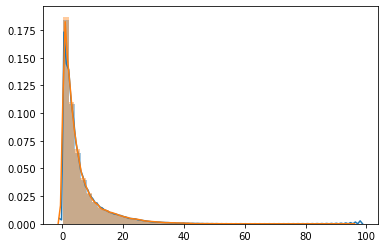

In [96]:
sn.distplot(train_y,label = 'Train CashFlow')
sn.distplot(test_y, label = 'Test CashFlow')

In [59]:
x.shape

(259527, 75)

In [97]:
cnt = 1024
model = tf.keras.Sequential([
                    tf.keras.layers.Dense(128, activation='relu',input_shape = [train_x.shape[1]]),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1(0.0001)),
                    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1(0.0001)), 
                    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1(0.0001)), 
                    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1(0.0001)), 
                    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1(0.0001)), 
                    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1(0.0001)), 
                    tf.keras.layers.Dense(1)       
])
model.compile(loss = 'mse',
              optimizer = tf.keras.optimizers.Adagrad(0.001),
              metrics = ['mae','mse'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 128)               9728      
_________________________________________________________________
dense_70 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_71 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_72 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_73 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_74 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_75 (Dense)             (None, 128)             

In [98]:
EPOCHS = 128
history = model.fit(
  train_x, train_y,
  batch_size = 64,
  epochs=EPOCHS, validation_data=(test_x,test_y))

Epoch 1/128
3125/3125 [==============================] - 12s 4ms/step - loss: 15.0568 - mae: 2.3017 - mse: 14.3073 - val_loss: 10.6191 - val_mae: 1.9252 - val_mse: 9.8712
Epoch 2/128
3125/3125 [==============================] - 12s 4ms/step - loss: 9.7202 - mae: 1.8335 - mse: 8.9740 - val_loss: 9.2230 - val_mae: 1.7484 - val_mse: 8.4784
Epoch 3/128
3125/3125 [==============================] - 14s 5ms/step - loss: 8.7070 - mae: 1.6980 - mse: 7.9640 - val_loss: 8.5482 - val_mae: 1.6574 - val_mse: 7.8068
Epoch 4/128
3125/3125 [==============================] - 15s 5ms/step - loss: 8.1710 - mae: 1.6226 - mse: 7.4313 - val_loss: 8.1793 - val_mae: 1.6006 - val_mse: 7.4412
Epoch 5/128
3125/3125 [==============================] - 12s 4ms/step - loss: 7.8267 - mae: 1.5740 - mse: 7.0901 - val_loss: 7.9309 - val_mae: 1.5683 - val_mse: 7.1959
Epoch 6/128
3125/3125 [==============================] - 12s 4ms/step - loss: 7.5785 - mae: 1.5401 - mse: 6.8451 - val_loss: 7.7653 - val_mae: 1.5419 - val_m

Epoch 98/128
3125/3125 [==============================] - 9s 3ms/step - loss: 5.3462 - mae: 1.2496 - mse: 4.7864 - val_loss: 6.1277 - val_mae: 1.2928 - val_mse: 5.5684
Epoch 99/128
3125/3125 [==============================] - 9s 3ms/step - loss: 5.3383 - mae: 1.2490 - mse: 4.7795 - val_loss: 6.1356 - val_mae: 1.2919 - val_mse: 5.5772
Epoch 100/128
3125/3125 [==============================] - 9s 3ms/step - loss: 5.3326 - mae: 1.2485 - mse: 4.7748 - val_loss: 6.1360 - val_mae: 1.2913 - val_mse: 5.5786
Epoch 101/128
3125/3125 [==============================] - 9s 3ms/step - loss: 5.3275 - mae: 1.2478 - mse: 4.7706 - val_loss: 6.1247 - val_mae: 1.2905 - val_mse: 5.5682
Epoch 102/128
3125/3125 [==============================] - 9s 3ms/step - loss: 5.3196 - mae: 1.2468 - mse: 4.7635 - val_loss: 6.1376 - val_mae: 1.2930 - val_mse: 5.5820
Epoch 103/128
3125/3125 [==============================] - 9s 3ms/step - loss: 5.3153 - mae: 1.2466 - mse: 4.7602 - val_loss: 6.1185 - val_mae: 1.2893 - val_

In [82]:
train_x.shape

(200000, 75)

In [76]:
model = tf.keras.Sequential([
                    tf.keras.layers.Dense(512, activation='relu',input_shape = [75]),
                    tf.keras.layers.Dense(512, activation='relu'),
                    tf.keras.layers.Dense(512, activation='relu'),
                    tf.keras.layers.Dense(512, activation='relu'), 
                    #tf.keras.layers.Dense(128, activation='relu'), 
                    #tf.keras.layers.Dense(128, activation='relu'), 
                    #tf.keras.layers.Dense(128, activation='relu'), 
                    #tf.keras.layers.Dense(128, activation='relu'), 
                    #tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(l=0.00001)),                 
                    #tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(l=0.0001)),
                    tf.keras.layers.Dense(1)       
])
model.compile(loss = 'mse',
              optimizer = tf.keras.optimizers.Adagrad(0.0001),
              metrics = ['mae','mse'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 512)               38912     
_________________________________________________________________
dense_51 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_52 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_53 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 513       
Total params: 827,393
Trainable params: 827,393
Non-trainable params: 0
_________________________________________________________________


In [77]:
EPOCHS = 64
history = model.fit(
  train_x, train_y,
  batch_size = 64,
  epochs=EPOCHS, validation_data=(test_x,test_y))

Epoch 1/64
3125/3125 [==============================] - 52s 17ms/step - loss: 25.6938 - mae: 3.3531 - mse: 25.6938 - val_loss: 52.5683 - val_mae: 4.0931 - val_mse: 52.5683
Epoch 2/64
3125/3125 [==============================] - 52s 17ms/step - loss: 12.3463 - mae: 2.1986 - mse: 12.3463 - val_loss: 34.2950 - val_mae: 3.2073 - val_mse: 34.2950
Epoch 3/64
3125/3125 [==============================] - 52s 17ms/step - loss: 8.9259 - mae: 1.8968 - mse: 8.9259 - val_loss: 30.3813 - val_mae: 3.1231 - val_mse: 30.3813
Epoch 4/64
3125/3125 [==============================] - 53s 17ms/step - loss: 8.2646 - mae: 1.8494 - mse: 8.2646 - val_loss: 29.5386 - val_mae: 3.1317 - val_mse: 29.5386
Epoch 5/64
3125/3125 [==============================] - 53s 17ms/step - loss: 7.8789 - mae: 1.8086 - mse: 7.8789 - val_loss: 29.1431 - val_mae: 3.1300 - val_mse: 29.1431
Epoch 6/64
3125/3125 [==============================] - 52s 17ms/step - loss: 7.5755 - mae: 1.7723 - mse: 7.5755 - val_loss: 29.1287 - val_mae: 3.

KeyboardInterrupt: 

In [70]:
train_x

array([[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  1.   ],
       [ 0.   ,  0.   ,  8.399, ...,  0.   ,  0.   ,  1.   ],
       [11.097, 11.18 ,  0.   , ...,  0.   ,  0.   ,  1.   ],
       ...,
       [ 3.739,  3.8  ,  3.913, ...,  1.   ,  1.   ,  1.   ],
       [ 0.   ,  0.   ,  0.   , ...,  1.   ,  1.   ,  1.   ],
       [ 1.238,  1.254,  1.289, ...,  0.   ,  0.   ,  1.   ]])

In [71]:
test_y

array([22.293377, 14.169633, 25.573283, ...,  2.181129,  2.908976,
        2.224539])

In [3]:
path = os.path.join(repodir,"train.txt")
df = pd.read_csv(path, sep = ';', header = None)

for filename in os.listdir(traindir):
    print(filename)
    path=os.path.join(traindir, filename)
    df1 = pd.read_csv(path, sep = ';', header = None)
    if df is None:
        df = df1
        continue
    df = pd.concat([df, df1])
train_df = df.iloc[:,:-1]
test1_df = pd.read_csv(os.path.join(testdir, "train_real.txt"), sep = ';', header = None).iloc[:,:-1]
test21_df = pd.read_csv(os.path.join(testdir, "test2_5084.txt"), sep = ';', header = None).iloc[:,:-1]
test22_df = pd.read_csv(os.path.join(testdir, "test2_72168.txt"), sep = ';', header = None).iloc[:,:-1]
test2_df = pd.concat([test21_df, test22_df])

print("train - {}, test1 - {}, test2 - {}".format(train_df.shape[0], test1_df.shape[0], test2_df.shape[0]))
train_df = train_df.drop_duplicates(subset = [0,1])
test2_df = test2_df.drop_duplicates(subset = [0,1])

print("train - {}, test1 - {}, test2 - {}".format(train_df.shape[0], test1_df.shape[0], test2_df.shape[0]))
lx = (test1_df.iloc[:,-14:-2] < -0.00001).any(axis = 1)
test1_df = test1_df[~lx]
print("test1 - {}".format(lx.sum()))

lx = (test2_df.iloc[:,-14:-2] < -0.00001).any(axis = 1)
test2_df = test2_df[~lx]
print("test2 - {}".format(lx.sum()))

lx = (train_df.iloc[:,-14:-2] < -0.00001).any(axis = 1)
train_df = train_df[~lx]
print("train - {}".format(lx.sum()))

print("train - {}, test1 - {}, test2 - {}".format(train_df.shape[0], test1_df.shape[0], test2_df.shape[0]))

for i in range(100):
    train_df = train_df.sample(frac = 1).reset_index(drop=True)

trainfilepath = os.path.join(repodir, 'train_{}'.format(train_df.shape[0]) )
train_df.to_csv(trainfilepath,index = False)

testfilepath1 = os.path.join(repodir, 'test_{}'.format(test1_df.shape[0]) )
test1_df.to_csv(testfilepath1,index = False)

testfilepath2 = os.path.join(repodir, 'test_{}'.format(test2_df.shape[0]) )
test2_df.to_csv(testfilepath2,index = False)

train_real_0_0_410_38_40938.txt
train_real_1600_0_46363.txt
train_real_1600_0_58256.txt
train_real_1600_0_61440.txt
train_real_1600_0_61657.txt
train_real_1600_0_67635.txt
train_real_410_0_9132.txt
train - 345421, test1 - 102230, test2 - 77252
train - 345420, test1 - 102230, test2 - 77252
test1 - 1
test2 - 0
train - 21764
train - 323656, test1 - 102229, test2 - 77252


# Train and build model

In [4]:
def to_category(freqv): 
    res = np.zeros((freqv.shape[0],12))
    for i in range(freqv.shape[0]):
        if freqv[i] == 1:
            res[i] = np.array([1,1,1,1,1,1,1,1,1,1,1,1],dtype = 'float')
        elif freqv[i] == 2:
            res[i] = np.array([0,1,0,1,0,1,0,1,0,1,0,1],dtype = 'float') 
        elif freqv[i] == 3:
            res[i] = np.array([0,0,1,0,0,1,0,0,1,0,0,1],dtype = 'float')
        elif freqv[i] == 4:
            res[i] = np.array([0,0,0,1,0,0,0,1,0,0,0,1],dtype = 'float')
        elif freqv[i] == 6:
            res[i] = np.array([0,0,0,0,0,1,0,0,0,0,0,1],dtype = 'float')
        elif freqv[i] == 12:
            res[i] = np.array([0,0,0,0,0,0,0,0,0,0,0,1],dtype = 'float')
    return res

def convertor(df):
    df.columns = ['n','id','bmode','tb1','tb2','tb3','tb4','tb5','tb6','tb7','tb8','tb9','tb10','tb11','tb12','tb13','tb14','tb15','tb16','tb17','tb18','tb19','tb20','tb21',
           'ts1','ts2','ts3','ts4','ts5','ts6','ts7','ts8','ts9','ts10','ts11','ts12','ts13','ts14','ts15','ts16','ts17','ts18','ts19','ts20','ts21',
           't1','t2','t3','t4','t5','t6','t7','t8','t9','t10','t11','t12','t13','t14','t15','t16','t17','t18','t19','t20','t21',
           'c1','c2','c3','c4','c5','c6','c7','c8','c9','c10','c11','c12','smode','freq']
    act_columns = ['tb1','tb2','tb3','tb4','tb5','tb6','tb7','tb8','tb9','tb10','tb11','tb12','tb13','tb14','tb15','tb16','tb17','tb18','tb19','tb20','tb21',
               'ts1','ts2','ts3','ts4','ts5','ts6','ts7','ts8','ts9','ts10','ts11','ts12','ts13','ts14','ts15','ts16','ts17','ts18','ts19','ts20','ts21',
               'c1','c2','c3','c4','c5','c6','c7','c8','c9','c10','c11','c12']
    coup_columns = ['c1','c2','c3','c4','c5','c6','c7','c8','c9','c10','c11','c12'] 
    target = df[coup_columns].sum(axis=1)
    data = df[act_columns].copy()
    data.loc[:,coup_columns] = to_category(df['freq'])
    return data,target

def VaR(ar):
    sar = np.sort(ar)
    sz = sar.shape[0]
    rsk = np.rint(sz * (1 - np.array([0.99,0.98,0.97,0.96,0.95,0.94,0.93,0.92,0.91,0.9]))).astype('int')
    return sar[rsk]

In [5]:
train_df = pd.read_csv(trainfilepath)
test1_df = pd.read_csv(testfilepath1)
test2_df = pd.read_csv(testfilepath2)
train_data, train_target = convertor(train_df)
test1_data, test1_target = convertor(test1_df)
test2_data, test2_target = convertor(test2_df)

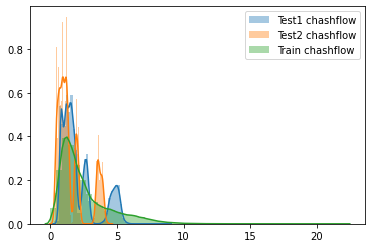

In [6]:
sn.distplot(test1_target,label = 'Test1 chashflow')
sn.distplot(test2_target,label = 'Test2 chashflow')
sn.distplot(train_target,label = 'Train chashflow')
plt.legend()

In [7]:
model = tf.keras.Sequential([
                    tf.keras.layers.Dense(128, activation='relu',input_shape = [len(train_data.keys())]),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1(0.0001)),
                    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1(0.0001)), 
                    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1(0.0001)), 
                    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1(0.0001)), 
                    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1(0.0001)), 
                    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1(0.0001)), 
                    #tf.keras.layers.Dense(64, activation='relu'),
                    #tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(l=0.00001)),                 
                    #tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(l=0.0001)),
                    tf.keras.layers.Dense(1)       
])
model.compile(loss = 'mse',
              optimizer = tf.keras.optimizers.Adagrad(0.001),
              metrics = ['mae','mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               7040      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1

In [8]:
EPOCHS = 256
history = model.fit(
  train_data, train_target,
  batch_size = 64,
  epochs=EPOCHS, validation_data=(test1_data,test1_target))

Epoch 1/256
5058/5058 [==============================] - 16s 3ms/step - loss: 0.9367 - mae: 0.2282 - mse: 0.1875 - val_loss: 0.7618 - val_mae: 0.1004 - val_mse: 0.0175
Epoch 2/256
5058/5058 [==============================] - 16s 3ms/step - loss: 0.7802 - mae: 0.1288 - mse: 0.0406 - val_loss: 0.7509 - val_mae: 0.0954 - val_mse: 0.0159
Epoch 3/256
5058/5058 [==============================] - 16s 3ms/step - loss: 0.7591 - mae: 0.1081 - mse: 0.0287 - val_loss: 0.7409 - val_mae: 0.0950 - val_mse: 0.0151
Epoch 4/256
5058/5058 [==============================] - 15s 3ms/step - loss: 0.7443 - mae: 0.0960 - mse: 0.0230 - val_loss: 0.7309 - val_mae: 0.0911 - val_mse: 0.0141
Epoch 5/256
5058/5058 [==============================] - 15s 3ms/step - loss: 0.7316 - mae: 0.0873 - mse: 0.0192 - val_loss: 0.7225 - val_mae: 0.0907 - val_mse: 0.0146
Epoch 6/256
5058/5058 [==============================] - 15s 3ms/step - loss: 0.7203 - mae: 0.0809 - mse: 0.0167 - val_loss: 0.7130 - val_mae: 0.0896 - val_mse:

5058/5058 [==============================] - 15s 3ms/step - loss: 0.2846 - mae: 0.0326 - mse: 0.0029 - val_loss: 0.2928 - val_mae: 0.0698 - val_mse: 0.0117
Epoch 98/256
5058/5058 [==============================] - 15s 3ms/step - loss: 0.2835 - mae: 0.0325 - mse: 0.0029 - val_loss: 0.2918 - val_mae: 0.0699 - val_mse: 0.0117
Epoch 99/256
5058/5058 [==============================] - 15s 3ms/step - loss: 0.2824 - mae: 0.0325 - mse: 0.0029 - val_loss: 0.2907 - val_mae: 0.0699 - val_mse: 0.0117
Epoch 100/256
5058/5058 [==============================] - 15s 3ms/step - loss: 0.2814 - mae: 0.0324 - mse: 0.0029 - val_loss: 0.2890 - val_mae: 0.0681 - val_mse: 0.0110
Epoch 101/256
5058/5058 [==============================] - 15s 3ms/step - loss: 0.2804 - mae: 0.0323 - mse: 0.0029 - val_loss: 0.2888 - val_mae: 0.0705 - val_mse: 0.0118
Epoch 102/256
5058/5058 [==============================] - 15s 3ms/step - loss: 0.2793 - mae: 0.0322 - mse: 0.0029 - val_loss: 0.2871 - val_mae: 0.0684 - val_mse: 0.0

5058/5058 [==============================] - 15s 3ms/step - loss: 0.2192 - mae: 0.0275 - mse: 0.0021 - val_loss: 0.2255 - val_mae: 0.0623 - val_mse: 0.0086
Epoch 194/256
5058/5058 [==============================] - 15s 3ms/step - loss: 0.2188 - mae: 0.0275 - mse: 0.0021 - val_loss: 0.2252 - val_mae: 0.0629 - val_mse: 0.0088
Epoch 195/256
5058/5058 [==============================] - 16s 3ms/step - loss: 0.2183 - mae: 0.0275 - mse: 0.0021 - val_loss: 0.2243 - val_mae: 0.0618 - val_mse: 0.0084
Epoch 196/256
5058/5058 [==============================] - 15s 3ms/step - loss: 0.2178 - mae: 0.0274 - mse: 0.0021 - val_loss: 0.2243 - val_mae: 0.0633 - val_mse: 0.0089
Epoch 197/256
5058/5058 [==============================] - 14s 3ms/step - loss: 0.2173 - mae: 0.0274 - mse: 0.0021 - val_loss: 0.2238 - val_mae: 0.0629 - val_mse: 0.0088
Epoch 198/256
5058/5058 [==============================] - 14s 3ms/step - loss: 0.2169 - mae: 0.0273 - mse: 0.0021 - val_loss: 0.2229 - val_mae: 0.0615 - val_mse: 0

In [9]:
version = 2
export_path = os.path.join(modeldir, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')

export_path = C:\Users\PLDD\Practice\GitHub\Python\MHS\models\2

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\PLDD\Practice\GitHub\Python\MHS\models\2\assets

Saved model:


In [10]:
y_act1 = test1_target.to_numpy()
y_pred1 = model.predict(test1_data).reshape(-1)
dff = pd.DataFrame({'Act': test1_target, 'Pred' : y_pred1})
dff.describe()

,Act,Pred
count,102229.000000,102229.000000
mean,2.119526,2.072973
std,1.353206,1.314965
min,0.322815,0.316071
25%,1.168864,1.136051
50%,1.603277,1.590016
75%,2.647212,2.600953
max,8.725821,8.152223


In [11]:
y_act2 = test2_target.to_numpy()
y_pred2 = model.predict(test2_data).reshape(-1)
dff = pd.DataFrame({'Act': test2_target, 'Pred' : y_pred2})
dff.describe()

,Act,Pred
count,77252.000000,77252.000000
mean,1.552110,1.568512
std,1.072593,1.115968
min,0.236809,0.299229
25%,0.766257,0.755042
50%,1.168075,1.158127
75%,1.960509,2.036500
max,4.360890,4.400702


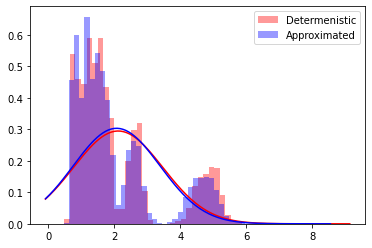

In [12]:
sn.distplot(y_act1,fit = stats.norm, color = 'red', label = 'Determenistic',fit_kws={"color":"red"},kde = False)
sn.distplot(y_pred1, fit = stats.norm, color = 'blue', label = 'Approximated',fit_kws={"color":"blue"},kde=False)
plt.legend()

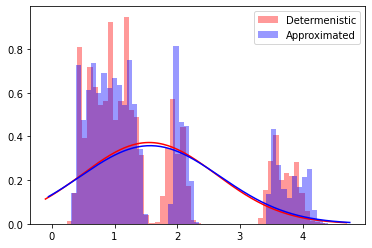

In [13]:
sn.distplot(y_act2,fit = stats.norm, color = 'red', label = 'Determenistic',fit_kws={"color":"red"},kde = False)
sn.distplot(y_pred2, fit = stats.norm, color = 'blue', label = 'Approximated',fit_kws={"color":"blue"},kde=False)
plt.legend()

export_path = C:\Users\PLDD\Practice\GitHub\Python\MHS\models\1

INFO:tensorflow:Assets written to: C:\Users\PLDD\Practice\GitHub\Python\MHS\models\1\assets

Saved model:
